<img src="../img/ods_stickers.jpg" />

## 决策树和 K 近邻分类

---

#### 介绍

本次实验分别运用决策树和最近邻方法在分类任务上构建模型，并通过交叉验证对模型进行调优。

#### 知识点

- 决策树
- 最近邻方法
- 交叉验证

---

### 机器学习介绍

在深入本次实验之前，首先了解一下什么是机器学习， Machine Learning（T. Mitchell 著，1997 年出版）一书中给出了机器学习经典、通用的定义：

>假设用 P 来评估计算机程序在某任务类 T 上的性能，若一个程序利用经验 E 在任务 T 上获得了性能改善，则我们就说关于 T 和 P, 该程序对 E 进行了学习。

在不同的问题设定下，T、P、E 可能指完全不同的东西。机器学习中一些流行的任务 T 包括：

- 分类：基于特征将实例分为某一类。
- 回归：基于实例的其他特征预测该实例的数值型目标特征。
- 聚类：基于实例的特征实现实例的分组，从而让组内成员比组间成员更为相似。
- 异常检测：寻找与其他样本或组内实例有很大区别的实例。
- 其他更多任务

关于经验 E，《Deep Learning》（Ian Goodfellow、Yoshua Bengio、Aaron Courville 著，2016 年出版）的「Machine Learning basics」一章提供了一份很好的综述：

>经验 E 指的是数据（没有数据我们什么也干不了）。根据训练方式，机器学习算法可以分为监督（supervised）和无监督（unsupervised）两类。无监督学习需要训练含有很多特征的数据集，然后学习出这个数据集上有用的结构性质。而监督学习的数据集除了含有很多特征外，它的每个样本都要有一个标签（label）或目标（target）。

#### 示例

分类和回归属于监督学习问题。例如，作为信贷机构，我们可能希望根据客户累积的数据预测贷款违约情况。在这里，经验 E 是已有的训练数据，即实例（客户）的集合，一组特征（例如年龄、薪水、贷款类型、以往违约记录等），一个目标变量（他们是否会违约）。由于需要预测的目标变量是「他们是否会违约」，所以这是一个二元分类问题。如果你转而预测贷款会超期多久，那么需要预测的目标变量变成了一个连续值（时间），这就成为一个回归问题了。

最后，关于算法表现的评估度量 P。不同问题和算法的度量不同，当学习新算法时，我们将讨论这一点。就目前而言，本次实验将使用分类算法中的一个简单度量标准，即准确率（Accuracy）。

下面看看分类和回归这两个监督学习问题。

### 决策树 

决策树是分类与回归问题中常用的方法之一。其实不仅是机器学习领域，在每天的日常决策中，我们都在使用决策树。流程图实际上就是决策树的可视化表示，例如，下面是俄罗斯国立高等经济研究大学（Higher School of Economics）提供的关于「如何在学院网站上发表论文」的流程图：

<img width='500px;' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557025112634'>

用机器学习的术语来说，可以把它看成一个简单的分类器，根据内容（书、小册子、论文）、新闻类型、原发表物类型（科学期刊、通讯）等来确定合适的发表类型（书、文章、书的章节、预印本、Higher School of Economics and the Media 稿件）。

决策树常常是专家经验的概括，是一种分享特定过程知识的方式。例如，在引入可扩展机器学习算法之前，银行业的信用评分任务是由专家解决的，能否放贷是基于一些直观（或经验）的规则，这些规则就可以表示为决策树的形式，如下图所示：

<img src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557025095926">

作为机器学习算法的决策树基本上和上图差不多，它合并一连串逻辑规则，使之成为一个树形的数据结构，这些规则的形式为「特征 a 的值小于 x，特征 b 的值小于 y … => 类别 1」。

下面，我们基于「年龄」、「房产」、「收入」、「教育」特征使用决策树解决一个二元分类问题，即「是否允许贷款」。

### 如何构建决策树

年龄、房产、收入、教育，这么多的特征首先应该关注哪个呢？

为了回答上述问题，先看一个简单的游戏，即「20个问题」游戏，这个游戏是这样玩的：A 心里想着一个名人，B 问 A 20 个问题，A 只能回答「是」或「否」，20 个问题之后 B 要猜出 A 心里想的那个名人是谁。首先问一个可以最大程度压缩剩余选项数目的问题会使 B 占据极大优势，例如询问「是不是安吉丽娜·朱莉？」，最多剔除一个选项，而询问「这个名人是女人吗？」将消除大约一半的选项。就是说，「性别」特征相比「安吉丽娜·朱莉」、「西班牙人」、「喜欢足球」等其他特征更能区分名人数据集。这背后的道理与熵有关，下面介绍熵的概念。

#### 熵

熵是一个在物理、信息论和其他领域中广泛应用的重要概念，可以衡量获得的信息量。对于具有 N 种可能状态的系统而言，熵的定义如下：

$$S = -\sum_{i=1}^{N}p_i \log_2{p_i},$$

其中，$p_i$ 是系统位于第 i 个状态的概率。熵可以描述为系统的混沌程度，熵越高，系统的有序性越差，反之亦然。熵将帮助我们高效的分割数据，类似帮助我们找出在「20个问题」游戏中先问什么问题较好。

#### 玩具示例

为了解释熵是如何有利于构建决策树模型的，让我们来看一个玩具示例，在这个示例中将基于球的位置预测它的颜色。

<img src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557025079468'>

这里有 9 个蓝球和 11 个黄球。如果随机选择一个球，这个球是蓝球的概率 $p_1=\frac{9}{20}$，是黄球的概率 $p_2=\frac{11}{20}$，这意味着熵 $S_0 = -\frac{9}{20}\log_2{\frac{9}{20}}-\frac{11}{20}\log_2{\frac{11}{20}} \approx 1$。这个值本身可能无法告诉我们很多信息。

将球分为「位置小于等于 12、位置大于 12」这两组，如下图所示。

<img src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557025058742'>

那么分组后，熵的变化如何？左边一组有 13 个球， 8 蓝 5 黄。这一组的熵 $S_1 = -\frac{5}{13}\log_2{\frac{5}{13}}-\frac{8}{13}\log_2{\frac{8}{13}} \approx 0.96$。右边一组有 7 个球， 1 蓝 6 黄。右边这组的熵 $S_2 = -\frac{1}{7}\log_2{\frac{1}{7}}-\frac{6}{7}\log_2{\frac{6}{7}} \approx 0.6$。可见，两组的熵都下降了，且右边这组降得更多。由于熵实际上是系统混沌（或不确定）的程度，熵的下降被称为信息增益。数学上，基于变量 Q（在这个例子中是变量「x ≤ 12」）所作的分割，得到的信息增益（IG）定义为：

$$IG(Q) = S_O - \sum_{i=1}^{q}\frac{N_i}{N}S_i,$$

其中，$q$ 是分割的组数，$N_i$ 是变量 Q 等于第 i 项时的样本数目。在玩具示例中，有 2 个组（$q = 2$），一组有 13 个元素（$N_1 = 13$），另一组有 7 个（$N_2 = 7$）。因此，信息增益为：

$$ IG(x \leq 12) = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$

结果表明，根据「坐标小于或等于12」将球分为两组带来了一个更有序的系统。让我们继续分组，直到每组中的球颜色都一样。

<img src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557025043052'>

上图可见，右边那组只需根据「坐标小于或等于 18」再分割一次即可。而左边那组还需要三次分割。注意，若组内所有球的颜色都一样，那么这个组的熵为 0（$\log_2{1} = 0$）。

通过这个例子，我们成功构建了一个基于球的位置预测球颜色的决策树。但倘若我们再向里面增加一个球，这个决策树就可能无法很好地工作，因为它完全拟合了训练集（初始的 20 球）。如果希望提升它的泛用性，那么一棵具有更少分支（「问题」）的决策树将有更好的效果。

### 决策树构建算法

在之前的例子中构建的决策树是最优的：它只需提 5 个「问题」（基于变量 Q），就完全拟合了训练集。其他分割条件会使得到的树更深，即需要更多「问题」才能获得答案。

构建决策树的流行算法（如 ID3 或 C4.5）的核心，是贪婪最大化信息增益：在每一步，算法都会选择能在分割后给出最大信息增益的变量。接着递归重复这一流程，直到熵为零（或者，为了避免过拟合，直到熵为某个较小的值）。不同的算法使用不同的推断，通过「提前停止」或「截断」以避免构建出过拟合的树。

### 分类问题中其他的分割质量标准

上面我们讨论了熵是如何衡量树的分区的，但还有其他指标来衡量分割的好坏：

- 基尼不确定性（Gini uncertainty）：$G = 1 - \sum\limits_k (p_k)^2$
- 错分率（Misclassification error）：$E = 1 - \max\limits_k p_k$

实践中几乎从不使用错分率，而基尼不确定性和信息增益的效果差不多。

 二元分类问题的熵和基尼不确定性为：

$$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})}$$

$$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+)$$

其中 $p_+$ 是对象具有标签 + 的概率。

以 $p_+$ 为坐标，绘制上面两个函数的图像。

In [1]:
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

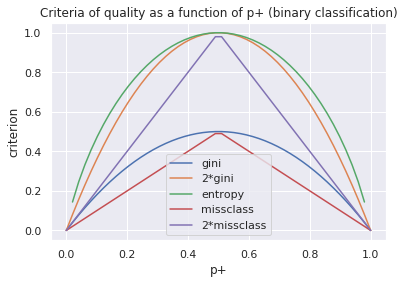

In [2]:
plt.figure(figsize=(6, 4))
xx = np.linspace(0, 1, 50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)
              for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Criteria of quality as a function of p+ (binary classification)')
plt.legend()

上图可见，熵的图像和两倍的基尼不确定性图像非常接近。因此，在实践中，这两个指标的效果基本上是一样的。

#### 示例

下面用一棵决策树拟合一些合成数据。这些合成数据属于两个不同的类别，这两个类别的均值不同，但都呈现正态分布。

In [3]:
# 第一类
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# 第二类
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

下面绘制数据。通俗地讲，这种情况下的分类问题就是构造一个「边界」，能够较好的分开两个类别（红点和黄点）。这个「边界」若是一条直线的话可能太过简单，若是沿着每个红点画出的蛇形曲线又太过复杂（这将导致其在新数据上的表现很差）。从直觉上说，某种平滑的边界，在新数据上的效果会比较好。

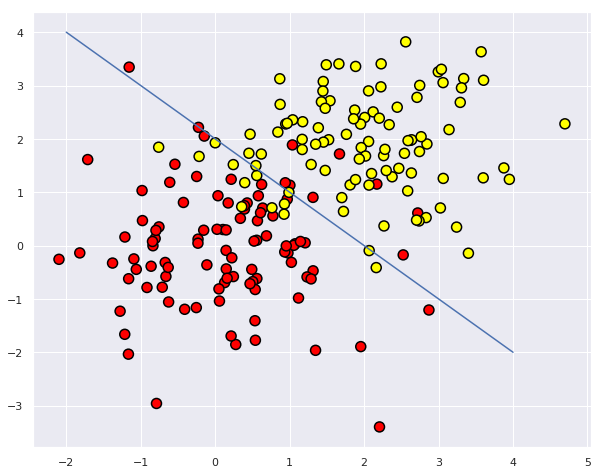

In [4]:
plt.figure(figsize=(10, 8))
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100,
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2, 5), range(4, -3, -1))

下面训练一棵 sklearn 决策树，区分这两类数据点。最后可视化所得的边界。

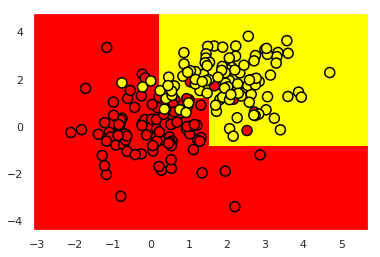

In [5]:
from sklearn.tree import DecisionTreeClassifier
# 编写一个辅助函数，返回之后的可视化网格


def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


#  max_depth参数限制决策树的深度
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                  random_state=17)
# 训练决策树
clf_tree.fit(train_data, train_labels)
# 可视化
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(),
                                   yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100,
            cmap='autumn', edgecolors='black', linewidth=1.5)

通过 pydotplus 和 export_graphviz 库我们可以方便的看到决策树本身是怎样的。使用 `StringIO()` 函数开辟一个缓存空间保存决策树，通过 `export_graphviz()` 函数以 DOT 格式导出决策树的 GraphViz 表示，然后将其写入 out_file 中。使用 `graph_from_dot_data()` 函数读入数据并通过 `Image()` 函数显示决策树。

In [6]:
!pip install pydotplus  # 安装必要模块

    100% |████████████████████████████████| 286kB 7.3MB/s eta 0:00:01
  Stored in directory: /tmp/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf_tree, feature_names=['x1', 'x2'],
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\xc8\x00\x00\x01\xf1\x08\x02\x00\x00\x00\x17\xe1\…

上图表明，在最深的一层，树将空间「切割」为8个矩形，也就是说，树有8个叶节点。在每个矩形之中，树将根据数量较多的对象的标签做出预测。

### 我们如何「读懂」这颗决策树？

上个示例中，总共有 200 个合成数据（样本），每个分类各有 100 个合成数据。初始状态的熵是最大的，即 $S=1$。接着，通过比较 $x_2$ 与 1.211 的大小进行第一次分割，将样本分成两组（你可以在上图中找到这一部分边界）。基于这一次分割，左右两组的熵都下降了。这一过程持续进行，直到树的深度达到 3。在上图中，属于第一类的样本数量越多，该节点的橙色就越深，属于第二类的样本越多，该节点的蓝色就越深。若两类样本的数量相等，则为白色，比如根节点的两类样本数量相同，所以它是白色的

### 决策树如何应用到数值特征？

假设有一个数值特征「年龄」，该特征有大量的唯一值。决策树将通过查看「年龄 < 17」、「年龄 < 22.87」这样的二元属性寻找最好的分割，分割的好坏由某种信息增益标准衡量。但在构建树的每一步中，会有过多的二元属性可供选择，比如「薪水」同样能以很多方式进行分割，为了解决这一问题，我们经常使用启发式算法来限制选择的属性数量。

看一个例子，假设有如下数据集：

In [8]:
data = pd.DataFrame({'Age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
                     'Loan Default': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]})
data

,Age,Loan Default
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


使用 `sort_values()` 方法根据年龄进行升序排列。

In [9]:
data.sort_values('Age')

,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


训练一个决策树模型，并可视化。

In [10]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data['Age'].values.reshape(-1, 1), data['Loan Default'].values)

dot_data = StringIO()
export_graphviz(age_tree, feature_names=['Age'],
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x03\x07\x08\x06\x00\x00\x00\xcfO\xa5…

上图可见，该决策树使用以下 5 个值来评估年龄：43.5、19、22.5、30、32。如果你仔细观察，你会发现它们就是目标变量（Loan Default）出现变化（从 1「切换」到 0 或从 0「切换」到 1）时那两个年龄的平均值。比如，一个 38 岁的客户没能偿还贷款（目标变量为 1），而一个 49 岁的客户还贷了（目标变量为 0），那么树使用的评估值就是 38 和 49 的均值，即 43.5。树寻找那些目标变量发生变化的值，以此作为「切割」的阈值。

下面考虑一个更复杂的例子，把「薪水」变量（以千美元每年为单位）加入数据集。

In [11]:
data2 = pd.DataFrame({'Age':  [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
                      'Salary': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88],
                      'Loan Default': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]})
data2.sort_values('Age')

,Age,Salary,Loan Default
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


上表可见，如果根据年龄排序，目标变量（Loan Default）将切换（从 1 到 0 或从 0 到 1）5 次。

下表可见，如果根据薪水排序，它将切换 7 次。

In [12]:
data2.sort_values('Salary')

,Age,Salary,Loan Default
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


下面看看树将如何选择特征。

In [13]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[['Age', 'Salary']].values, data2['Loan Default'].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [14]:
dot_data = StringIO()
export_graphviz(age_sal_tree, feature_names=['Age', 'Salary'],
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xfc\x00\x00\x02|\x08\x02\x00\x00\x00\x94h\x84\x0…

上图表明，树同时根据薪水和年龄进行分区，有些节点的分割阈值选择了年龄，有些选择了薪水。树为何选择这些特征？因为根据基尼不确定性质量标准，它们提供了更好的分区。

结论：决策树处理数值特征最简单的启发式算法是升序排列它的值，然后只关注目标变量发生改变的那些值。

此外，当数据集具有大量数值特征，且每个特征具有大量唯一值时，只选择最高的N个阈值，即，仅仅使用提供最高增益的前N个值。这一过程可以看成是构造了一棵深度为 1 的树，计算熵（或基尼不确定性），然后选择最佳阈值用于比较。比方说，如果我们根据「薪水 ≤ 34.5」分割，左子组的熵为 0（所有客户都是「不好的」），而右边的熵为 0.954（3 个「不好的」，5 个「好的」，你可以自行确认这一点，这将作为作业的一部分），信息增益大概是 0.3。如果我们根据「薪水 ≤ 95」分割，左边的子组的熵会是 0.97（6 个「不好的」，4 个「好的」），而右边的熵会是 0（该组只包含 1 个对象），信息增益大约是  0.11。如果以这样的方式计算每种分区的信息增益，那么在使用所有特征构造一棵大决策树之前就可以选出每个数值特征的阈值。

### 树的关键参数

理论上讲，我们可以构建一个决策树，直到每个叶节点只有一个实例，但这样做容易过拟合，导致其在新数据上的表现不佳。如果你这么做，在树的最深处，可能会存在由无关紧要的特征组成的分区，例如根据「客户裤子的颜色」这一特征进行分区，这是我们不希望发生。

但在两种情况下，树可以被构建到最大深度（每个叶节点只有一个实例）：

- 随机森林。它将构建为最大深度的单个树的响应进行平均（稍后我们将讨论为什么要这样做）。
- 决策树修剪。在这种方法中，树首先被构造成最大深度。然后，从底部开始，基于交叉验证来比较有分区/无分区情形下树的质量情况，进而移除树的一些节点。

下图是过拟合的决策树给出的分界。

<img width='400px;' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557025021753'>


常见的解决决策树过拟合的方法为：

- 人工限制深度或叶节点的最少样本数。

- 对树进行剪枝。

### scikit-learn 的 DecisionTreeClassifier 类

sklearn.tree.DecisionTreeClassifier 类的主要参数为：

- max_depth 树的最大深度；
- max_features 搜索最佳分区时的最大特征数（特征很多时，设置这个参数很有必要，因为基于所有特征搜索分区会很「昂贵」）；
- min_samples_leaf 叶节点的最少样本数。

树的参数需要根据输入数据设定，通常通过交叉验证可以确定参数范围，下文会具体讨论交叉验证。

### 回归问题中的决策树

当对数值变量进行预测时，我们构造决策树的思路和分类问题时所用的思路是一样的，但衡量决策树好坏的质量标准改变了，现在它的质量标准如下：

$$D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{j=1}^{\ell} y_j)^2, $$


其中，$\ell$ 是叶节点中的样本数，$y_i$ 是目标变量的值。简单来说，通过最小化方差，使每个叶子中的目标特征的值大致相等，以此来划分训练集的特征。

#### 示例

让我们基于以下函数生成一些带噪数据：

$$f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$$

接着在生成的数据上训练一颗决策树，并进行预测，调用 `plt` 方法画出结果示意图。

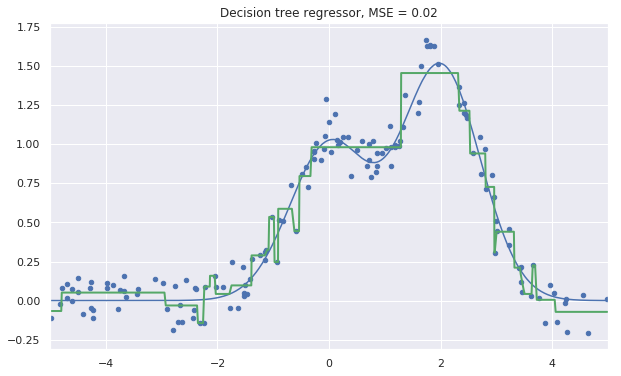

In [15]:
from sklearn.tree import DecisionTreeRegressor
n_train = 150
n_test = 1000
noise = 0.1


def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y


X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)


reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" %
          (np.sum((y_test - reg_tree_pred) ** 2) / n_test))
plt.show()

上图表明，决策树使用分段的常数函数逼近数据。

### 最近邻方法

最近邻方法（K 近邻或 k-NN）是另一个非常流行的分类方法。当然，也可以用于回归问题。和决策树类似，这是最容易理解的分类方法之一。这一方法遵循紧密性假说：如果样本间的距离能以足够好的方法衡量，那么相似的样本更可能属于同一分类。

比如，根据最近邻方法，下图中的绿球将被分类为「蓝色」而不是「红色」，因为它与蓝球的距离更近。

<img src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557025005732'>

再举一个例子，如果你不知道蓝牙耳机属于什么类别，你可以查找 5 个相似的耳机，如果其中 4 个标记为「配件」类，只有 1 个标记为「科技」类，那么根据最近邻方法，它属于「配件」类。

在最近邻方法中，为了对测试集中的每个样本进行分类，需要依次进行以下操作：

- 计算训练集中每个样本之间的距离。
- 从训练集中选取 k 个距离最近的样本。
- 测试样本的类别将是它 k 个最近邻中最常见的分类。

在回归问题中应用最近邻方法很简单，仅需将上述步骤做一个小小的改动：第三步不返回分类，而是返回一个数字，即目标变量在邻居中的均值或中位数。

这一方式的显著特点是它具有惰性：当需要对测试样本进行分类时，计算只在预测阶段进行。由于这种特点，最近邻方法事先并不基于训练样本创建模型，这与上文提到的决策树不同。决策树是基于训练集构建的，在预测阶段仅通过遍历决策树就可以实现快速地分类。

### 最近邻方法的实际应用

- 在某些案例中，k-NN 可以作为一个模型的基线。
- 在 Kaggle 竞赛中，k-NN 常常用于构建元特征（即 k-NN 的预测结果作为其他模型的输入），或用于堆叠/混合。
- 最近邻方法还可以扩展到推荐系统等任务中。
- 在大型数据集上，常常使用逼近方法搜索最近邻。

k-NN 分类/回归的效果取决于一些参数：

- 邻居数 k。
- 样本之间的距离度量（常见的包括 Hamming，欧几里得，余弦和 Minkowski 距离）。注意，大部分距离要求数据在同一尺度下，例如「薪水」特征的数值在千级，「年龄」特征的数值却在百级，如果直接将他们丢进最近邻模型中，「年龄」特征就会受到比较大的影响。
- 邻居的权重（每个邻居可能贡献不同的权重，例如，样本越远，权重越低）。

### scikit-learn 的 KNeighborsClassifier 类

`sklearn.neighbors.KNeighborsClassifier` 类的主要参数为：

- weights：可设为 uniform（所有权重相等），distance（权重和到测试样本的距离成反比），或任何其他用户自定义的函数。
- algorithm（可选）：可设为 brute、ball_tree、KD_tree、auto。若设为 brute，通过训练集上的网格搜索来计算每个测试样本的最近邻；若设为 ball_tree 或 KD_tree，样本间的距离储存在树中，以加速寻找最近邻；若设为 auto，将基于训练集自动选择合适的寻找最近邻的方法。
- leaf_size（可选）：若寻找最近邻的算法是 BallTree 或 KDTree，则切换为网格搜索所用的阈值。
- metric：可设为 minkowski、manhattan、euclidean、chebyshev 或其他。

### 选择模型参数和交叉验证

机器学习算法的主要任务是可以「泛化」未曾见过的数据。由于我们无法立刻得知模型在新数据上的表现（因为还不知道目标变量的真值），因此有必要牺牲一小部分数据，来验证模型的质量，即将一小部分数据作为留置集。

通常采用下述两种方法之一来验证模型的质量：

- 留置法。保留一小部分数据（一般是 20% 到 40%）作为留置集，在其余数据上训练模型（原数据集的 60%-80%），然后在留置集上验证模型的质量。
- 交叉验证。最常见的情形是 k 折交叉验证，如下图所示。

<img width='500px;' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557024973868'>

在 k 折交叉验证中，模型在原数据集的 $K-1$ 个子集上进行训练（上图白色部分），然后在剩下的 1 个子集上验证表现，重复训练和验证的过程，每次使用不同的子集（上图橙色部分），总共进行 K 次，由此得到 K 个模型质量评估指数，通常用这些评估指数的求和平均数来衡量分类/回归模型的总体质量。

相比留置法，交叉验证能更好地评估模型在新数据上的表现。然而，当你有大量数据时，交叉验证对机器计算能力的要求会变得很高。

交叉验证是机器学习中非常重要的技术，同时也应用于统计学和经济学领域。它有助于我们进行超参数调优、模型比较、特征评估等其他重要操作。你可以点击 [<i class="fa fa-external-link-square" aria-hidden="true"> 这里</i>](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html)以了解更多关于交叉验证的信息 。

### 应用样例

#### 在客户离网率预测任务中使用决策树和最近邻方法

首先读取数据至 DataFrame 并进行预处理。将 State 特征从 DateFrame 转移到单独的 Series 对象中。我们训练的第一个模型将不包括 State 特征，之后再考察 State 特征是否有用。

In [16]:
df = pd.read_csv(
    '../../data/telecom_churn.csv')

df['International plan'] = pd.factorize(df['International plan'])[0]
df['Voice mail plan'] = pd.factorize(df['Voice mail plan'])[0]
df['Churn'] = df['Churn'].astype('int')
states = df['State']
y = df['Churn']
df.drop(['State', 'Churn'], axis=1, inplace=True)

In [17]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


之后将数据集的 70% 划分为训练集（X_train,y_train），30% 划分为留置集（X_holdout,y_holdout）。留置集的数据在调优模型参数时不会被用到，在调优之后，用它评定所得模型的质量。

接下来，训练 2 个模型：决策树和 k-NN。一开始，我们并不知道如何设置模型参数能使模型表现好，所以可以使用随机参数方法，假定树深（max_dept）为 5，近邻数量（n_neighbors）为 10。

In [18]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,
                                                          random_state=17)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

使用准确率（Accuracy）在留置集上评价模型预测的质量。

In [19]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.94

In [20]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)

0.881

从上可知，决策树的准确率约为 94%，k-NN 的准确率约为 88%，于是仅使用我们假定的随机参数（即没有调参），决策树的表现更好。

现在，使用交叉验证确定树的参数，对每次分割的 max_dept（最大深度 h）和 max_features（最大特征数）进行调优。`GridSearchCV()` 函数可以非常简单的实现交叉验证，下面程序对每一对 max_depth 和 max_features 的值使用 5 折验证计算模型的表现，接着选择参数的最佳组合。

In [21]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {'max_depth': range(5, 7),
               'max_features': range(16, 18)}

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(5, 7), 'max_features': range(16, 18)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

列出交叉验证得出的最佳参数和相应的训练集准确率均值。

In [22]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [23]:
tree_grid.best_score_

0.9425632233176168

In [24]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.946

绘制所得的决策树。

In [25]:
dot_data = StringIO()
export_graphviz(tree_grid.best_estimator_, feature_names=df.columns,
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x11S\x00\x00\x03\x91\x08\x02\x00\x00\x00n`\x12~\x00\…

现在，再次使用交叉验证对 k-NN 的 k 值（即邻居数）进行调优。

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

knn_pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': range(6, 8)}

knn_grid = GridSearchCV(knn_pipe, knn_params,
                        cv=5, n_jobs=-1,
                        verbose=True)

knn_grid.fit(X_train, y_train)

knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


({'knn__n_neighbors': 7}, 0.8859837119588513)

In [27]:
knn_grid.best_params_

{'knn__n_neighbors': 7}

In [28]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.89

从上可知，在 1-9 范围（range 不包括 10）内最优的 k 值为 7，其交叉验证的准确率约为 88.5%，调优后 k-NN 在留置集上的准确率约为 89%。

综上所述，在这个任务里，决策树有着 94%/94.6%（留置法/交叉验证调优后）的准确率，k-NN 有着 88%/89%（留置法/交叉验证调优后）的准确率，显然决策树的表现更好。

使用 `RandomForestClassifier()` 方法再训练一个随机森林（可以把它想象成一群互相协作的决策树），看看能否在这个任务上有更好的表现。

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                random_state=17)
np.mean(cross_val_score(forest, X_train, y_train, cv=5))

0.9494233119813256

In [30]:
forest_params = {'max_depth': range(8, 10),
                 'max_features': range(5, 7)}

forest_grid = GridSearchCV(forest, forest_params,
                           cv=5, n_jobs=-1, verbose=True)

forest_grid.fit(X_train, y_train)
forest_grid.best_params_, forest_grid.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.2s finished


({'max_depth': 9, 'max_features': 6}, 0.9511358765537934)

In [31]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout))

0.953

从上可知，随机森林有着 95.3% 的准确率。不得不说，决策树在这个任务上的表现非常好，即使是训练时间长得多的随机森林也无法取得比它更好的表现。

### 决策树的复杂情况

为了继续讨论决策树和 k-NN 的优劣，让我们考虑另外一个简单的分类任务，在这个任务中决策树的表现不错但得到的分类边界过于复杂。

首先，在一个平面上创建一组具有 2 个分类的数据点，每个数据点是两个分类中的一个（红色表示 $x_1>x_2$，黄色表示 $x_1<x_2$），其实用一条直线 $x_1 = x_2$ 就可以完成它们的分类，那么决策树会这么做吗？

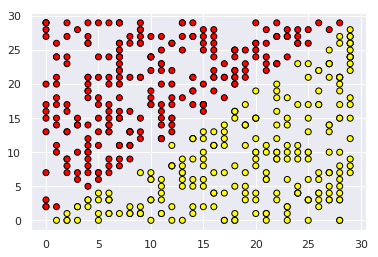

In [32]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30,
                                 x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1 = np.random.randint(x1_min, x1_max)
        x2 = np.random.randint(x2_min, x2_max)
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)


X, y = form_linearly_separable_data()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='black')

训练一个决策树对上面的数据进行分类，并绘制分类边界。

Text(0.5, 1.0, 'Easy task. Decision tree compexifies everything')

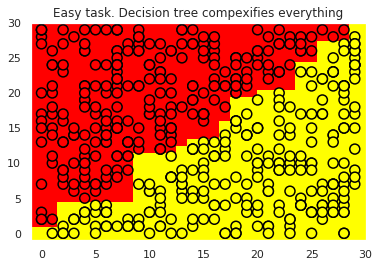

In [33]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100,
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Easy task. Decision tree compexifies everything')

可视化决策树。

In [34]:
dot_data = StringIO()
export_graphviz(tree, feature_names=['x1', 'x2'],
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08K\x00\x00\x04\x1c\x08\x06\x00\x00\x00gI\x87\xf3\x…

从上可知，决策树构建的边界过于复杂，而且树的深度过深，产生了过拟合现象。

再训练一个 k-NN 模型，看看它在这个任务上的表现情况。该单元格执行时间较长，建议在线下练习：

<pre style="font-size:14px; line-height:17px;" class="hljs">
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

xx, yy = get_grid(X)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100,
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Easy task, kNN. Not bad')
</pre>

![图片描述](https://doc.shiyanlou.com/courses/uid214893-20190505-1557037780636)

从上可知，最近邻方法的表现比决策树好一点，但仍然比不上线性分类器 $x_1 = x_2$（线性分类器将是下一个实验的内容）。

###  在 MNIST 手写数字识别任务中应用决策树和 k-NN

现在可以看看这两个算法应用到实际任务上的表现如何，首先载入 sklearn 内置的 MNIST 手写数字数据集，该数据库中手写数字的图片为 8x8 的矩阵，矩阵中的值表示每个像素的白色亮度。

In [35]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target

X[0, :].reshape([8, 8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

绘制一些 MNIST 手写数字。

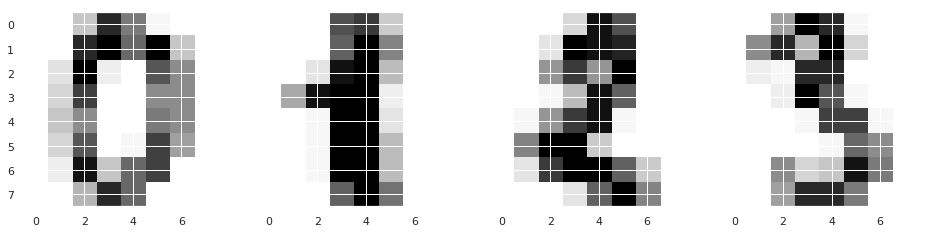

In [36]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 6))
for i in range(4):
    axes[i].imshow(X[i, :].reshape([8, 8]), cmap='Greys')

使用 `train_test_split()` 方法分割数据集，其中的 70% 作为训练集（X_train，y_train），30% 作为留置集（X_holdout，y_holdout）。

In [37]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17)

使用随机参数训练决策树和 k-NN。

In [38]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn_pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier(n_neighbors=10))])

tree.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform'))])

训练好之后，分别在留置集上做出预测。

In [39]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn_pipe.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(
    y_holdout, tree_pred)  # (0.976, 0.666)

(0.975925925925926, 0.6666666666666666)

从上可知，k-NN 做得更好，不过别忘了我们用的是随机参数。现在，使用交叉验证调优决策树模型，因为这次任务所需考虑的特征比之前任务中的更多，所以可以增加参数的大小。

In [40]:
tree_params = {'max_depth': [10, 20, 30],
               'max_features': [30, 50, 64]}

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.4s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [10, 20, 30], 'max_features': [30, 50, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

查看交叉验证得到的最佳参数组合和相应的准确率。

In [41]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 20, 'max_features': 64}, 0.8440731901352426)

调优后决策树模型的准确率达到了 84.4%，但还不到使用随机参数的 k-NN 的准确率（97%）。现在，使用交叉验证调优 k-NN 模型。

In [42]:
np.mean(cross_val_score(KNeighborsClassifier(
    n_neighbors=1), X_train, y_train, cv=5))

0.9865458422397149

从上可知，调优后的 k-NN 在这一数据集上可以达到 98.7% 的准确率。

下面在这一数据集上训练随机森林模型，在大多数数据集上，它的效果比 k-NN 要好。

In [43]:
np.mean(cross_val_score(RandomForestClassifier(
    random_state=17), X_train, y_train, cv=5))

0.9349085619110404

从上可知，在这个数据集中随机森林的准确率（93.5%）不如 k-NN（98.7%）。当然，我们没有对随机森林的参数进行任何调优，但即使经过调优，训练精确度也无法超过 k-NN。

决策树、k-NN、随机森林在这个数据集上的准确率如下所示：

|   算法\方式      |   留置法  | 交叉验证 |  
|---------|-------|---------|
| 决策树  | 0.667 |  0.844  |  
| k-NN | 0.976 |  0.987  |
| 随机森林  | / |  0.934  | 

从这个任务中得到的结论（同时也是一个通用的建议）：首先查看简单模型（决策树、最近邻）在你的数据上的表现，因为可能仅使用简单模型就已经表现得足够好了。

### 最近邻方法的复杂情形

下面考虑另一种情况，即在一个分类问题中，某个特征直接和目标变量成比例的情况。

In [44]:
def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    np.seed = random_seed
    y = np.random.choice([-1, 1], size=n_obj)
    # 第一个特征与目标成比例
    x1 = 0.3 * y
    # 其他特征为噪声
    x_other = np.random.random(size=[n_obj, n_feat - 1])
    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y


X, y = form_noisy_data()

使用最近邻方法训练模型后，查看交叉验证和留置集的准确率，并绘制这两个准确率随 n_neighbors 最近邻数目 参数变化的曲线，这样的曲线被称为验证曲线。

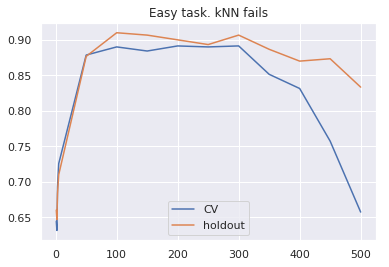

In [45]:
from sklearn.model_selection import cross_val_score
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17)


cv_scores, holdout_scores = [], []
n_neighb = [1, 2, 3, 5] + list(range(50, 550, 50))

for k in n_neighb:

    knn_pipe = Pipeline([('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier(n_neighbors=k))])
    cv_scores.append(np.mean(cross_val_score(
        knn_pipe, X_train, y_train, cv=5)))
    knn_pipe.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(
        y_holdout, knn_pipe.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('Easy task. kNN fails')
plt.legend()

上图表明，即使我们尝试在较广范围内改变 n_neighbors 参数，基于欧几里得距离的 k-NN 在这个问题上依旧表现不佳。

下面用决策树训练一个模型，看看它在这个任务上的表现如何。

In [46]:
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
print('Decision tree. CV: {}, holdout: {}'.format(
    tree_cv_score, tree_holdout_score))

Decision tree. CV: 1.0, holdout: 1.0


在这一任务中，决策树完美地解决了问题，在交叉验证和留置集上都得到了 100% 的准确率。其实，k-NN 之所以在这个任务上表现不佳并非该方法本身的问题，而是因为使用了欧几里得距离，因为欧几里得距离没能察觉出有一个特征（成比例）比其他所有特征（噪声）更重要。

### 决策树和最近邻方法的优势和劣势

#### 决策树

优势：

- 生成容易理解的分类规则，这一属性称为模型的可解释性。例如它生成的规则可能是「如果年龄不满 25 岁，并对摩托车感兴趣，那么就拒绝发放贷款」。
- 很容易可视化，即模型本身（树）和特定测试对象的预测（穿过树的路径）可以「被解释」。
- 训练和预测的速度快。
- 较少的参数数目。
- 支持数值和类别特征。

劣势：

- 决策树对输入数据中的噪声非常敏感，这削弱了模型的可解释性。
- 决策树构建的边界有其局限性：它由垂直于其中一个坐标轴的超平面组成，在实践中比其他方法的效果要差。
- 我们需要通过剪枝、设定叶节点的最小样本数、设定树的最大深度等方法避免过拟合。
- 不稳定性，数据的细微变动都会显著改变决策树。这一问题可通过决策树集成方法来处理（以后的实验会介绍）。
- 搜索最佳决策树是一个「NP 完全」（NP-Complete）问题。了解什么是 NP-Complete 请点击 [<i class="fa fa-external-link-square" aria-hidden="true"> 这里</i>](https://baike.baidu.com/item/NP-Complete/15961931?fr=aladdin)。实践中使用的一些推断方法，比如基于最大信息增益进行贪婪搜索，并不能保证找到全局最优决策树。
- 倘若数据中出现缺失值，将难以创建决策树模型。Friedman 的 CART 算法中大约 50% 的代码是为了处理数据中的缺失值（现在 sklearn 实现了这一算法的改进版本）。
- 这一模型只能内插，不能外推（随机森林和树提升方法也是如此）。也就是说，倘若你预测的对象在训练集所设置的特征空间之外，那么决策树就只能做出常数预测。比如，在我们的黄球和蓝球的例子中，这意味着模型将对所有位于 >19 或 <0 的球做出同样的预测。

#### 最近邻方法

优势：

- 实现简单。
- 研究很充分。
- 通常而言，在分类、回归、推荐问题中第一个值得尝试的方法就是最近邻方法。
- 通过选择恰当的衡量标准或核，它可以适应某一特定问题。

劣势：

- 和其他复合算法相比，这一方法速度较快。但是，现实生活中，用于分类的邻居数目通常较大（100-150），在这一情形下，k-NN 不如决策树快。
- 如果数据集有很多变量，很难找到合适的权重，也很难判定哪些特征对分类/回归不重要。
- 依赖于对象之间的距离度量，默认选项欧几里得距离常常是不合理的。你可以通过网格搜索参数得到良好的解，但在大型数据集上的耗时很长。
- 没有理论来指导我们如何选择邻居数，故而只能进行网格搜索（尽管基本上所有的模型，在对其超参数进行调整时都使用网格搜索的方法）。在邻居数较小的情形下，该方法对离散值很敏感，也就是说，有过拟合的倾向。
- 由于「维度的诅咒」，当数据集存在很多特征时它的表现不佳。

### 实验总结

本次实验我们通过决策树和最近邻方法在几个简单示例上构建了分类模型，并基于交叉验证的方法对模型进行调优，之后对比了决策树和最近邻方法的优劣情况。这两种方法常常作为机器学习模型的基线，熟悉他们的用法是十分必要的。

<i class="fa fa-link" aria-hidden="true"> 相关链接</i>

- [<i class="fa fa-external-link-square" aria-hidden="true"> scikit-learn 文档</i>](http://scikit-learn.org/stable/documentation.html) 
- [<i class="fa fa-external-link-square" aria-hidden="true"> scikit-learn 指南</i>](https://github.com/amueller/scipy-2017-sklearn)
- [<i class="fa fa-external-link-square" aria-hidden="true"> 机器学习优秀课程</i>](https://github.com/diefimov/MTH594_MachineLearning) 
- [<i class="fa fa-external-link-square" aria-hidden="true"> 适合决策树和 k-NN 的机器学习算法实现</i>](https://github.com/rushter/MLAlgorithms)
- [<i class="fa fa-external-link-square" aria-hidden="true"> 了解实验楼《楼+ 机器学习和数据挖掘课程》</i>](https://www.shiyanlou.com/louplus/)